In [1]:
%matplotlib inline
from models.plottings import *
setup_levitator()

3.10.8 (main, Nov 24 2022, 08:09:04) [Clang 14.0.6 ]


# Vereinfachte Simulation des akustischen Levitators "Tiny-Lev"
Akustische Levitatoren sind Geräte, die auf der Wirkung von Ultraschallwellen basieren, um Gegenstände in der Luft schweben zu lassen. Sie werden häufig in Laboren verwendet, um Gegenstände zu isolieren und zu untersuchen, ohne sie mit anderen Substanzen in Berührung zu bringen. Der Levitator besteht aus zwei oder mehr Sendern, die Ultraschallwellen mit einer Frequenz von $40kHz$ aussenden. Die Sender sind so angeordnet, dass die Wellen an der Oberseite der zu levitierenden Substanz fokussiert werden, wodurch ein Druckgradient entsteht, der die Substanz schweben lässt.

Um physikalische Zusammenhänge besser erklären zu können, wird im Folgenden zunächst ein vereinfachtes Modell des Gerätes mit nur 2 Sendern betrachtet.

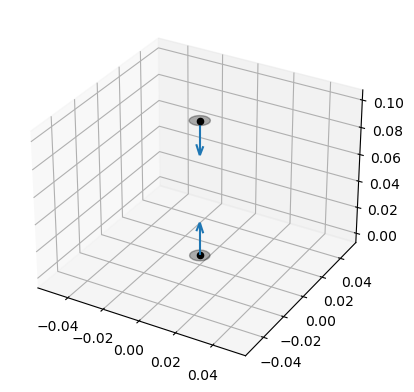

In [2]:
bottom_transducer = Transducer(np.array([0,0,0]), np.array([0,0,1]), 0)
top_transducer = Transducer(np.array([0,0,params.HEIGHT]), np.array([0,0,-1]), 0)

plot_transducers(bottom_transducer, top_transducer)

## Wellengleichungen
### Vereinfacht
Die von den Sendern ausgesandten Wellen verändern den Luftdruck an jedem Punkt des Levitators und erzeugen so ein akustisches Feld. Der akustische Druck $P$ im Punkt $p$ lässt sich durch folgende Wellengleichung annähern.
$$\Psi(p)=sin(t+K*d)$$
Hierbei steht $t$ für gegenwärtige Phase des Piezos, $d$ der Abstand des Piezos zum Punkt $p$ und $K=\frac{2\pi}{\lambda}$ ist die Wellenzahl.

### Komplex: Direktivitätsfunktion $D_f(\theta)$

Die Näherung des Piezos als Punktquelle ist physikalisch allerdings unakkurat, wehalb die einfache Wellenfunktion $\Psi$ um Folgendes erweitert werden muss:
1. Die Stärke des akustischen Feldes verhält sich antiproportional zur Distanz vom Piezo zum Punkt $p$. So muss die Gleichung um den   Faktor $\frac1d$ erweitert werden.
2. Der Piezo erzeugt ein gerichtetes Druckfeld. Die Senderichtung eines Piezos wird durch einen Normalenvektor $\vec{n}$ beschrieben, der orthogonal auf dessen Membran steht. Je größer der Winkel zwischen der Normalen $\vec(n)$ und dem Punkt ist, desto kleiner wird das Feld. So muss eine Direktivitätsfunktion $D_f(\theta)$ definiert, die vom Winkel $\theta$ zwischen Normalen und Punkt abhängt.

Der Winkel $\theta$ lässt sich über das Skalarprodukt der Piezonormalen $\vec{n}$ und des Vektors $\vec{Tp}$ vom Piezo zum Punkt $p$ berechnen. Es gilt
$$\theta = arccos(\frac{\vec{n} * \vec{Tp}}{|\vec{n}| * |\vec{Tp}|})$$
Die Direktivitätsfunktion für einen Piezo lautet
$$D_f(\theta) = \frac{2*J_1(k*a*sin(\theta)}{k*a*sin(\theta)}$$
mit $J_1$ als erste Bessel Funktion erster Ordnung und dem Membranradius $a$.
Sie kann mit
$$D_f(\theta) \approx sinc(k*a*sin(\theta) = \frac{sin(k*a*sin(\theta)}{\theta}$$
angenähert werden. Es gilt also die Gleichung
$$P = \frac{2*J_1(k*a*sin(\theta)}{k*a*sin(\theta)}*\frac{e^{i(t+k*d)}}{d}$$
Aus Performance Gründen wird hier der $sin$ aus der vereinfachten Gleichung durch den reellen Teil von $e^{i*(x+\frac{\pi}{2})}$ ersetzt. Diese Terme sind per Definition gleich.
So ergibt sich folgende Wellenintensität um den Sender im Bereich den Levitators.

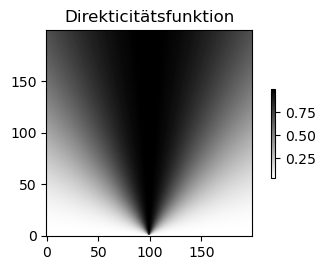

In [3]:
plot_directivity_function()

Im Folgenden wird immer die Ergebnisse der vereinfachten Wellenfunktion $\Psi$ auf der linken Seite und der komplexen Wellenfunktion $P$ auf der rechten Seite dargestellt. Aus den erläuterten Gleichungen ergeben sich folgende Wellen:

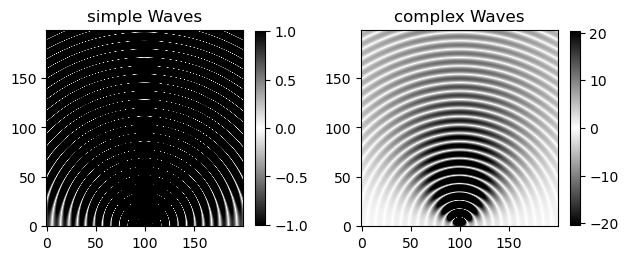

In [4]:
plot_pressure_waves(transducers=bottom_transducer, left="simple", right="complex")

## Interferenz
### Stehende Wellen
Überlagern sich zwei Wellen, entsteht Interferenz. Das bedeutet, dass sich die Wellen addieren. Im besonderen Falle, dass die interferierenden Wellen von gleicher Frequenz, Phase und Amplitude sind bilden sich Knotenpunkte und Wellenbäuche. In den Knotenpunkten ändert sich der Luftdruck nicht. An den Wellenbäuchen oszilliert er stark.
Ein solches Interferenzbild $I$ kann durch die Addition der interferierenden Wellen berechnet werden:
$$I=\sum_{i=1}^{n}P_i$$
Die zwei Sender des Vereinfachten Levitators erzeugen folgendes Interferenzbild.

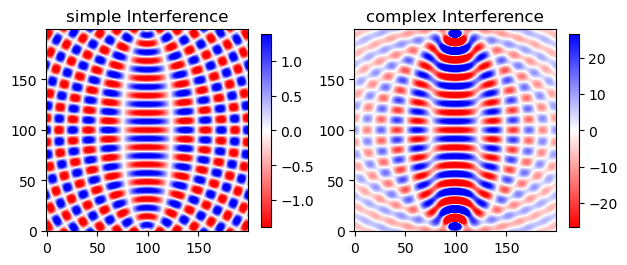

In [5]:
plot_interference([[bottom_transducer], [top_transducer]], left="simple", right="complex")

Während der Druck an einem Knotenpunkt konstant null ist verläuft der Druck in einem Wellenbauch wie folgt:

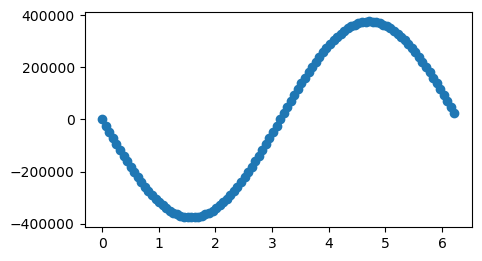

In [6]:
plot_pressure_over_time(bottom_transducer, np.array([0,.0000001,0]))

### Bestimmen von Knotenpunkten und Wellenbäuchen
Da der Druck an den Knotenpunkten konstant neutral ist, während er sich unmittelbar daneben an den Wellenäuchen stark ändert, kommt es zu Druckgradienten. Diese sorgen ultimativ für die Kraft, die ein Objekt schweben lässt. Es gilt also Knotenpunkte und Wellenbäuche im Interferenzbild ausfindig zu machen. Hierfür gitb es allerdings eine Schwierigkeit:

Für jeden Tupel (Sender-Punkt Distanz $d$; Zeit $t$) $T$ mit $d+t=n*\pi \forall n \in \mathbb{N}$ gilt $P=0$. Dies stellt ein Problem zur Identifikation von Knoten dar, da Bäuche an diesen Punkten nicht mehr von Knoten unterschieden werden können. In einem Aufbau mit mehr als zwei Sendern ist es nicht möglich dieses Problem durch das Betrachten eines Zeitpunktes, zu dem die oben gestellte Bedingung nicht erfüllt ist, zu umgehen, da die Zahl der Sender so groß ist, dass die Bedingung für fast jeden Zeitpunkt für einige Sender (nahezu) erfüllt ist. Dadurch würden an diesem Punkt starkt oszillierende Wellen, die zu diesem Zeitpunkt $0$ sind, im Ergebnis nicht beachtet werden. Dies verfälscht die Ergebnisse.
Eine Möglichkeit das Problem zu lösen, ist die Bestimmung der absoluten Luftdruckänderung eines Punktes über die gesamte Phase hinweg. Diese Druckänderung ist in der obenstehenden Abbildung die Fläche $A$, die der Luftdruck mit der Zeit einschließt. Diese lässt sich berechnen mit
$$A = |\int_{0}^{\pi} P \,dt| + |\int_{\pi}^{2*\pi} P \,dt|$$

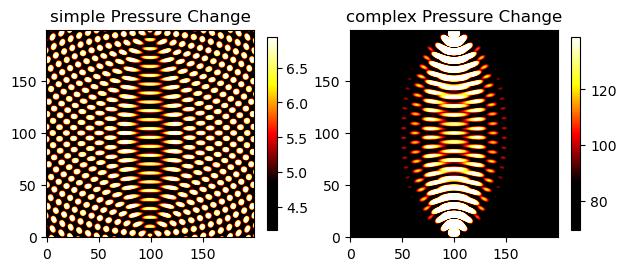

In [7]:
plot_pressure_change(([bottom_transducer], [top_transducer]), left="simple", right="complex")

In den schwazen Bereichen gilt nun, dass die Luftdruckänderung relativ gering ist. In den hervorgehobenen Bereichen ändert sich der Druck stark. Die Kraft, die ein Präparat schweben lässt, ist relativ zur Änderung dieses Drucks. Das heißt, dass Präparate aus Bereichen hohen Luftdrucks, hin zu Bereichen geringen Luftdrucks bewegt werden. So ist Levitation an Knotenpunkten (schwarz), die in alle Raumrichtungen hin, mit markierten Wellenbäuchen umgeben sind, möglich

# Vollständige Simulation

In dem tatsächlich verwendeten Levitator werden $2*36$ Sender verwendet, die jeweils oben und unten so auf einer Halbschale angeordnet sind, dass die auf den Mittelpunkt des Gerätes fokussiert sind.

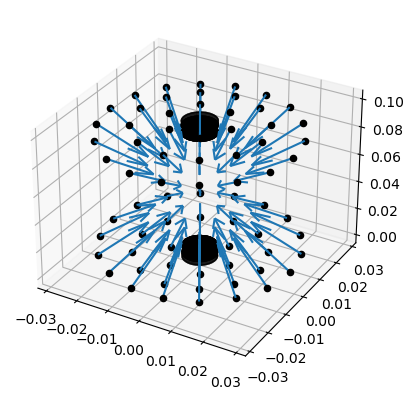

In [8]:
plot_transducers()

Diese Sender erzeugen folgende Wellen

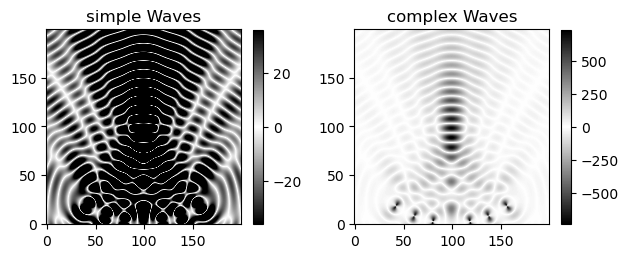

In [9]:
plot_pressure_waves(left="simple", right="complex")

So entsteht folgendes Interferenzbild

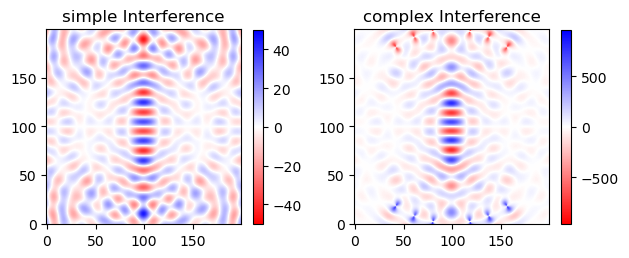

In [10]:
plot_interference(left="simple", right="complex")

Es ergibt sich folgende Druckänderung

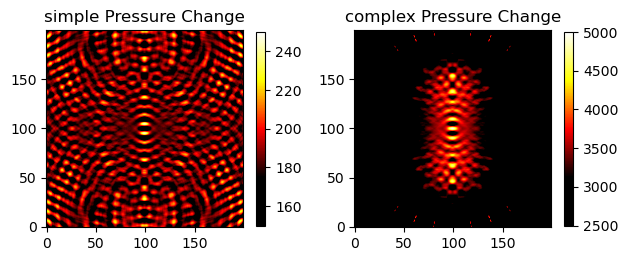

In [11]:
plot_pressure_change(left="simple", right="complex")

# Interpretation

Da für die physikalische Interpretation der Plots nur die akkurate Version relevant ist, wird im Folgenden nur noch diese betrachtet.

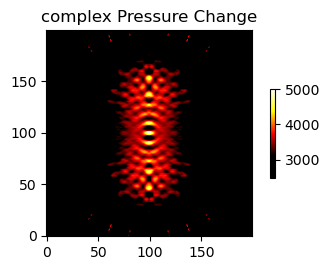

In [12]:
plot_pressure_change(left="complex")

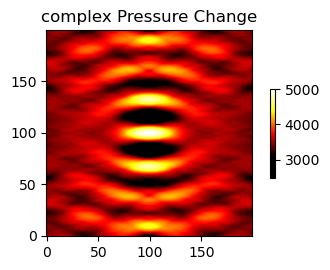

In [13]:
x = np.linspace(-.01,.01, params.RES)
z = np.linspace((params.HEIGHT/2)-.015, (params.HEIGHT/2)+.015, params.RES)
x,z = np.meshgrid(x,z)

plot_pressure_change(left="complex", x=x, z=z)

Der Zoom in das Zentrum das Levitators offenbart zwei Eigenschaften des Levitators:
1. Das Verwenden vieler Sender erzeugt ein wesentlich stärker auf das Zentrum fokussiertes Feld
2. Die schwarzen Knoten, in denen Levitation möglich ist, sind stärker nach oben und unten abegegrenzt, als zu den Seiten. Die sogenannte "Trapping-Force", die ein Präparat schweben lässt ist somit in vertikaler Richtung stärker, als in horizontaler.

# Visualisierung der Kräfte

Die Kraft $F$, die auf ein schwebendes Teilchen wirkt, wirkt immer von Gebieten einer hohen Druckänderung $A$ zu Gebieten geringer Druckänderung. Sie wirkt also entlang des Druckänderungsgradienten. Es gilt
$$F\sim \frac{dA}{dx,dy,dz}$$
Dieser Druckänderungsgradient lässt sich durch einen Oberflächenplot, in dem die Druckänderung aus der Z-Achse abgebildet ist, gut visualisieren.

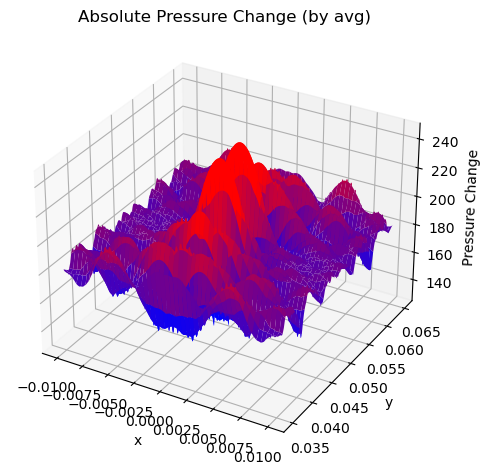

In [14]:
plot_plane(x=x, z=z)

In dieser Darstellung kann sich ein schwebendes Objekt als Kugel vorgestellt werden. Wird sie an einem Punkt hohen Potentials/Druckänderung platziert, rollt sie auf schnellstem Wege in das nächstgelegene Tal (blau) und erreicht so ein Minimalpotential. Aus diesem Tal kann das Objekt ohne zusätzliche Energie nicht mehr entweichen. Es ist dort gefangen - schwebt also an einem Punkt minimalen Potentials im Raum.

# Weiterführende Überlegungen

1. Um die Kräfte, die durch das Feld erzeugt werden besser verstehen zu können, wäre es interessant diese anhand der Ableitung des Drucks in die drei Raumrichtungen zu bestimmen. Hierbei kann sich die Linearität einer Ableitung zunutze gemacht werden, die es ermöglicht, die drei Ableitungen einzeln zu berechnen und dann zu addieren.
2. Da die Kraft entlang des steilsten Weges in dem Oberflächenplot wirkt, wäre es auch interessant diese als Weg/Pfad zu bestimmen und einzuzeichnen.
3. Den Betrag der Kraft könnte man farbig anhand der Steigung in den Oberflächenplot einzeichnen.
4. Um die Punkte, an denen Levitation möglich ist, auch in zwei Dimensionen sichtbar zu machen, muss Änderung der Druckänderung festgestellt werden. Ein grafischer Ansatz um diese Unterschiede herauszustellen, wäre der Einsatz einer Faltungsmatrix (convolution kernel), auf die ein Laplace'scher Kantenfilter angewandt wird. Die Kanten, die so hervorgehoben werden, umranden so die Knotenpunkte, in denen Levitation möglich ist.